# Quick Start (PyTorch)

Welcome to the quick start guide for running the **PyTorch** version of the AlphaGenome model.

This notebook mirrors the JAX reference notebook but uses the PyTorch implementation from `alphagenome_pytorch`.

The goal of this tutorial is to quickly get you up to speed with running the model and making some predictions using PyTorch.

## Prerequisites

- **GPU**: NVIDIA GPU with CUDA support (H100, A100, or similar recommended)
- **PyTorch**: With CUDA enabled
- **Hugging Face Token**: For downloading model weights
- Familiarity with the [AlphaGenome API](https://www.alphagenomedocs.com/)

In [1]:
# @title Install dependencies (run once)
# Uncomment and run if needed:
# !pip install torch
# !pip install git+https://github.com/google-deepmind/alphagenome_research.git
# !pip install python-dotenv

## Imports

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

import torch
import numpy as np
import pandas as pd
import matplotlib

from alphagenome.data import gene_annotation
from alphagenome.data import genome
from alphagenome.data import transcript as transcript_utils
from alphagenome.visualization import plot_components
from alphagenome.models import dna_output

# JAX model for loading weights (will be converted to PyTorch)
from alphagenome_research.model import dna_model as jax_dna_model

# PyTorch implementation
from alphagenome_pytorch import create_from_jax_model, set_update_running_var

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"HF_TOKEN set: {bool(os.environ.get('HF_TOKEN'))}")

/homes/gws/tuxm/Project/alphagenome/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.10.0+cu128
CUDA available: True
GPU: NVIDIA RTX A4500
HF_TOKEN set: True


## Loading the DNA Model

We load the JAX model from Hugging Face and convert it to PyTorch. This provides the same API as the JAX version (`predict_interval`, `predict_variant`, etc.) while using PyTorch for inference.

In [3]:
# Load JAX model (will be used for weight conversion)
print("Loading JAX model from Hugging Face...")
jax_model = jax_dna_model.create_from_huggingface('all_folds')
print("JAX model loaded.")

# Convert to PyTorch
print("\nConverting to PyTorch...")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = create_from_jax_model(jax_model, device=device)
set_update_running_var(model.model, False)

# Free JAX model memory immediately
del jax_model
import gc
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("JAX model memory freed.")

# Skip splice junctions to reduce memory usage
model.settings.num_splice_sites = 0
print("Splice junctions: DISABLED (for memory efficiency)")

print(f"\nPyTorch model ready on {device}")
print(f"Total parameters: {model.model.total_parameters:,}")
if torch.cuda.is_available():
    print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

Loading JAX model from Hugging Face...


Fetching 12 files: 100%|██████████| 12/12 [00:00<00:00, 88768.34it/s]
/homes/gws/tuxm/Project/alphagenome/.venv/lib/python3.11/site-packages/pyfaidx/__init__.py:589: UserWarning: for fsspec: HTTPFileSystem assuming index is current
  warnings.warn("for fsspec: %s assuming index is current" % type(self._fs).__name__)
/homes/gws/tuxm/Project/alphagenome/.venv/lib/python3.11/site-packages/pyfaidx/__init__.py:589: UserWarning: for fsspec: HTTPFileSystem assuming index is current
  warnings.warn("for fsspec: %s assuming index is current" % type(self._fs).__name__)


JAX model loaded.

Converting to PyTorch...
JAX model memory freed.
Splice junctions: DISABLED (for memory efficiency)

PyTorch model ready on cuda
Total parameters: 450,421,125
GPU memory allocated: 1.83 GB


## Track Metadata

We can see how many human tracks the model has been trained on:

In [4]:
from alphagenome.models import dna_model as dna_model_types

print('Number of human tracks per output type\n')
metadata = model.output_metadata(dna_model_types.Organism.HOMO_SAPIENS)

total = 0
for output_type in dna_output.OutputType:
    num_tracks = len(metadata.get(output_type)) if metadata.get(output_type) is not None else 0
    # Splice junctions are strand agnostic, so return 2 * num_tracks.
    if output_type == dna_output.OutputType.SPLICE_JUNCTIONS:
        num_tracks *= 2
    total += num_tracks
    print(f'{output_type.name:<20} {num_tracks}')
print(f'\n{"Total:":<20} {total}')

Number of human tracks per output type

ATAC                 167
CAGE                 546
DNASE                305
RNA_SEQ              667
CHIP_HISTONE         1116
CHIP_TF              1617
SPLICE_SITES         4
SPLICE_SITE_USAGE    734
SPLICE_JUNCTIONS     734
CONTACT_MAPS         28
PROCAP               12

Total:               5930


## Reproducing Paper Figures

For the rest of this tutorial, we will reproduce several figures from the AlphaGenome manuscript using the PyTorch model and the visualization library.

In [5]:
# Load GTF for transcript annotations
gtf = pd.read_feather(
    'https://storage.googleapis.com/alphagenome/reference/gencode/'
    'hg38/gencode.v46.annotation.gtf.gz.feather'
)

# Set up transcript extractors using the information in the GTF file.
gtf_transcripts = gene_annotation.filter_protein_coding(gtf)
gtf_transcripts = gene_annotation.filter_to_mane_select_transcript(gtf_transcripts)
transcript_extractor = transcript_utils.TranscriptExtractor(gtf_transcripts)
print(f"Loaded {len(gtf_transcripts)} MANE Select transcripts")

Loaded 499817 MANE Select transcripts


### Figure 2a

This figure presents several AlphaGenome track predictions in the HepG2 cell line.

**Note**: Using a 32kb interval for memory efficiency. For larger intervals (up to 1MB), use a GPU with more memory (A100/H100 with 40GB+ recommended).

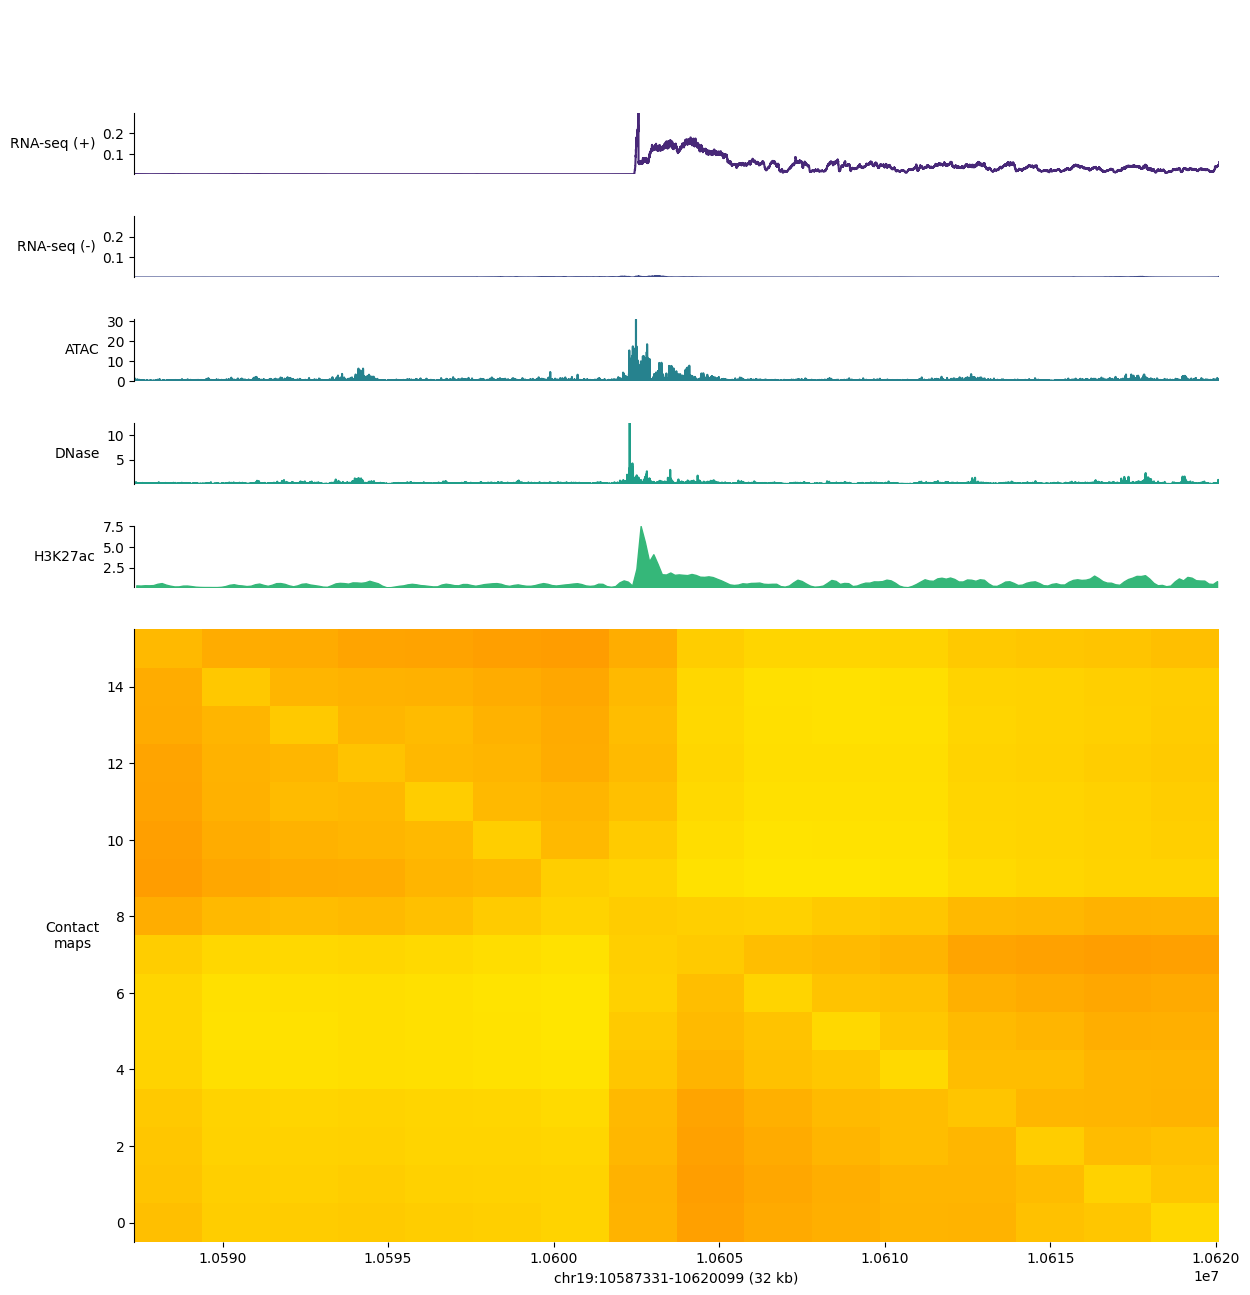

In [6]:
def _get_colors_hex(cmap_name, n):
    cmap = matplotlib.colormaps[cmap_name]
    return [matplotlib.colors.rgb2hex(cmap(i)) for i in np.linspace(0, 1, n)][1:]

# Clear GPU cache before prediction
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Using 32kb interval for memory efficiency (original was 1MB)
interval = genome.Interval('chr19', 10_587_331, 10_587_331 + 2**15, strand='+')

predictions = model.predict_interval(
    interval,
    requested_outputs={
        dna_output.OutputType.RNA_SEQ,
        dna_output.OutputType.DNASE,
        dna_output.OutputType.ATAC,
        dna_output.OutputType.CHIP_TF,
        dna_output.OutputType.CHIP_HISTONE,
        dna_output.OutputType.CONTACT_MAPS,
    },
    ontology_terms=['EFO:0001187'],  # HepG2 cell line
)
colors_hex = _get_colors_hex('viridis', 10)

output_rna_seq = predictions.rna_seq.filter_tracks(
    (predictions.rna_seq.metadata['Assay title'] == 'total RNA-seq').values
)

output_chip_histone = predictions.chip_histone.filter_tracks(
    (predictions.chip_histone.metadata['histone_mark'] == 'H3K27ac').values
)

output_chip_tf = predictions.chip_tf.filter_tracks(
    (
        (predictions.chip_tf.metadata['transcription_factor'] == 'CTCF')
        & (predictions.chip_tf.metadata['genetically_modified'].isnull())
    ).values
)

_ = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(
            transcript_extractor.extract(interval)
        ),
        plot_components.Tracks(
            output_rna_seq,
            ylabel_template='RNA-seq ({strand})',
            track_colors=colors_hex[0:2],
            shared_y_scale=True,
        ),
        plot_components.Tracks(
            predictions.atac,
            ylabel_template='ATAC',
            track_colors=colors_hex[3],
            shared_y_scale=True,
        ),
        plot_components.Tracks(
            predictions.dnase,
            ylabel_template='DNase',
            track_colors=colors_hex[4],
            shared_y_scale=True,
        ),
        plot_components.Tracks(
            output_chip_histone,
            ylabel_template='H3K27ac',
            filled=True,
            track_colors=colors_hex[5],
            shared_y_scale=True,
        ),
        plot_components.Tracks(
            output_chip_tf,
            ylabel_template='CTCF',
            filled=True,
            track_colors=colors_hex[6],
            shared_y_scale=True,
        ),
        plot_components.ContactMaps(
            predictions.contact_maps,
            ylabel_template='Contact\nmaps',
        ),
    ],
    interval=interval,
    fig_width=14,
    xlabel='{}:{}-{} (32 kb)'.format(
        interval.chromosome, interval.start, interval.end
    ),
)

# Clear memory after figure
del predictions
if torch.cuda.is_available():
    torch.cuda.empty_cache()

### Figure 3c (Skipped)

This figure shows splice junction predictions, which requires `model.settings.num_splice_sites > 0`.

**Skipped**: Splice junction inference is disabled to reduce memory usage. Enable it on larger GPUs by setting `model.settings.num_splice_sites = 256` after model loading.

In [7]:
# Figure 3c requires splice junctions which are disabled for memory efficiency.
# To enable, set model.settings.num_splice_sites = 256 after model loading.
print("Figure 3c skipped (splice junctions disabled)")

Figure 3c skipped (splice junctions disabled)


### Figure 4b

Example predictions for a known eQTL (chr22:36201698:A>C) with SuSiE PIP > 0.9 in GTEx Colon (Sigmoid) tissue.

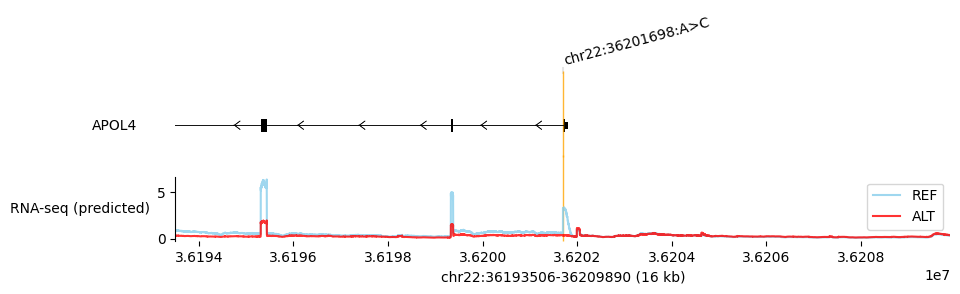

In [8]:
# Clear GPU cache before prediction
if torch.cuda.is_available():
    torch.cuda.empty_cache()

variant = genome.Variant.from_str('chr22:36201698:A>C')
# Using 32kb interval for memory efficiency
interval = variant.reference_interval.resize(2**15)

predictions = model.predict_variant(
    interval,
    variant,
    requested_outputs=[dna_output.OutputType.RNA_SEQ],
    ontology_terms=['UBERON:0001159'],  # Colon Sigmoid
)

ref_alt_colors = {'REF': 'skyblue', 'ALT': 'red'}
# Plot interval must be within predicted interval
plot_interval = interval.resize(2**14)  # 16kb centered

_ = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(
            transcript_extractor.extract(interval)
        ),
        plot_components.OverlaidTracks(
            tdata={
                'REF': predictions.reference.rna_seq.filter_to_unstranded(),
                'ALT': predictions.alternate.rna_seq.filter_to_unstranded(),
            },
            colors=ref_alt_colors,
            ylabel_template='RNA-seq (predicted)',
        ),
    ],
    annotations=[plot_components.VariantAnnotation([variant])],
    interval=plot_interval,
    fig_width=10,
    xlabel='{}:{}-{} (16 kb)'.format(
        plot_interval.chromosome, plot_interval.start, plot_interval.end
    ),
)

# Clear memory after figure
del predictions
if torch.cuda.is_available():
    torch.cuda.empty_cache()

### Figure 5e

Example AlphaGenome predictions for selected caQTLs. Shown are ALT-REF differences in a predicted DNase track (GM12878).

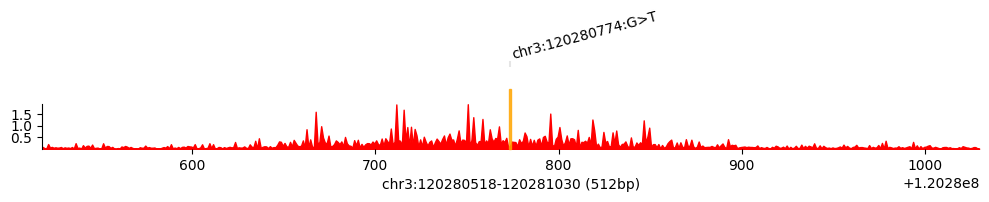

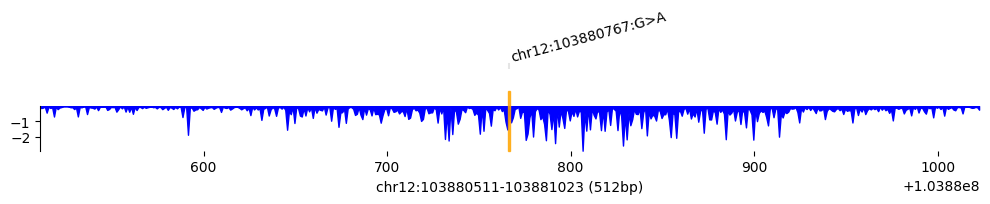

In [9]:
# Clear GPU cache before prediction
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# First variant
variant = genome.Variant.from_str('chr3:120280774:G>T')
interval = variant.reference_interval.resize(2**15)

predictions = model.predict_variant(
    interval,
    variant,
    requested_outputs=[dna_output.OutputType.DNASE],
    ontology_terms=['EFO:0002784'],  # GM12878
)

# Plot a 512bp region centered on variant (must be within interval)
plot_interval = variant.reference_interval.resize(512)

figure = plot_components.plot(
    [
        plot_components.Tracks(
            predictions.alternate.dnase - predictions.reference.dnase,
            ylabel_template='',
            track_colors='red',
            filled=True,
        ),
    ],
    annotations=[plot_components.VariantAnnotation([variant])],
    interval=plot_interval,
    fig_width=10,
    xlabel='{}:{}-{} (512bp)'.format(
        plot_interval.chromosome, plot_interval.start, plot_interval.end
    ),
)
figure.tight_layout()

# Clear memory
del predictions
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Second variant
variant = genome.Variant.from_str('chr12:103880767:G>A')
interval = variant.reference_interval.resize(2**15)

predictions = model.predict_variant(
    interval,
    variant,
    requested_outputs=[dna_output.OutputType.DNASE],
    ontology_terms=['EFO:0002784'],  # GM12878
)

# Plot a 512bp region centered on variant
plot_interval = variant.reference_interval.resize(512)

figure = plot_components.plot(
    [
        plot_components.Tracks(
            predictions.alternate.dnase - predictions.reference.dnase,
            ylabel_template='',
            track_colors='blue',
            filled=True,
        ),
    ],
    annotations=[plot_components.VariantAnnotation([variant])],
    interval=plot_interval,
    fig_width=10,
    xlabel='{}:{}-{} (512bp)'.format(
        plot_interval.chromosome, plot_interval.start, plot_interval.end
    ),
)
figure.tight_layout()

# Clear memory
del predictions
if torch.cuda.is_available():
    torch.cuda.empty_cache()

### Figure 6b

Detailed ALT-REF predictions for an oncogenic insertion (chr1:47239296:C>ACG) characterized in Mansour *et al.* 2014.

Notebook complete!


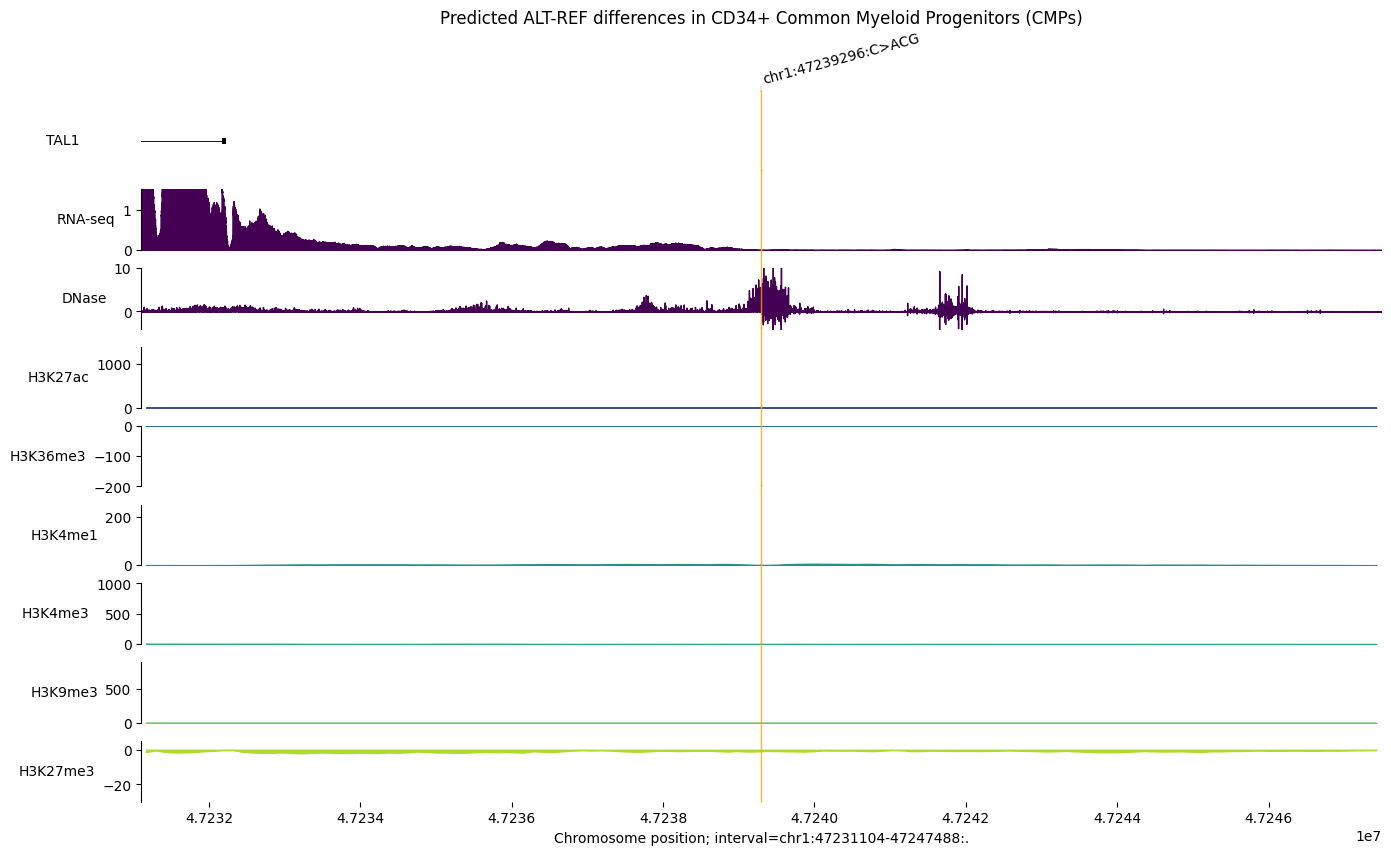

In [10]:
# Clear GPU cache before prediction
if torch.cuda.is_available():
    torch.cuda.empty_cache()

variant = genome.Variant.from_str('chr1:47239296:C>ACG')
# Using 32kb interval for memory efficiency
interval = variant.reference_interval.resize(2**15)

prediction = model.predict_variant(
    interval,
    variant,
    ontology_terms=['CL:0001059'],  # CD34+ Common Myeloid Progenitors
    requested_outputs={
        dna_output.OutputType.RNA_SEQ,
        dna_output.OutputType.CHIP_HISTONE,
        dna_output.OutputType.DNASE,
    },
)

# Plot interval within predicted range
plot_interval = interval.resize(2**14)  # 16kb centered

# Get chip_histone ALT-REF for negative strand
chip_alt_ref = (
    prediction.alternate.chip_histone.filter_to_nonpositive_strand()
    - prediction.reference.chip_histone.filter_to_nonpositive_strand()
)

# Helper to filter by histone mark name
def get_histone_track(tdata, histone_mark):
    """Filter track data by histone mark name."""
    mask = (tdata.metadata['histone_mark'] == histone_mark).values
    if mask.sum() == 0:
        return None
    return tdata.filter_tracks(mask)


def _get_colors_hex(cmap_name, n):
    cmap = matplotlib.colormaps[cmap_name]
    return [matplotlib.colors.rgb2hex(cmap(i)) for i in np.linspace(0, 1, n)][1:]


colors_hex = _get_colors_hex('viridis', 9)

# Build plot components, skipping missing histone marks
plot_items = [
    plot_components.TranscriptAnnotation(
        transcript_extractor.extract(interval)
    ),
    # RNA-seq tracks.
    plot_components.Tracks(
        tdata=(
            prediction.alternate.rna_seq.filter_to_nonpositive_strand()
            - prediction.reference.rna_seq.filter_to_nonpositive_strand()
        ),
        ylabel_template='RNA-seq',
        shared_y_scale=True,
        filled=True,
        global_ylims=(0, 1.5),
    ),
    # DNase tracks.
    plot_components.Tracks(
        tdata=(
            prediction.alternate.dnase.filter_to_nonpositive_strand()
            - prediction.reference.dnase.filter_to_nonpositive_strand()
        ),
        ylabel_template='DNase',
        shared_y_scale=True,
        filled=True,
        global_ylims=(-4, 10),
    ),
]

# Add histone tracks if available
histone_configs = [
    ('H3K27ac', (0, 1400), colors_hex[1]),
    ('H3K36me3', (-200, 0), colors_hex[2]),
    ('H3K4me1', (0, 250), colors_hex[3]),
    ('H3K4me3', (0, 1000), colors_hex[4]),
    ('H3K9me3', (0, 900), colors_hex[5]),
    ('H3K27me3', (-30, 5), colors_hex[6]),
]

for histone_mark, ylims, color in histone_configs:
    histone_track = get_histone_track(chip_alt_ref, histone_mark)
    if histone_track is not None:
        plot_items.append(
            plot_components.Tracks(
                histone_track,
                ylabel_template=histone_mark,
                shared_y_scale=True,
                global_ylims=ylims,
                filled=True,
                track_colors=color,
            )
        )

_ = plot_components.plot(
    plot_items,
    annotations=[plot_components.VariantAnnotation([variant])],
    interval=plot_interval,
    fig_width=16,
    title=(
        'Predicted ALT-REF differences in CD34+ Common Myeloid Progenitors'
        ' (CMPs)'
    ),
)

# Final memory cleanup
del prediction
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("Notebook complete!")

In [11]:
print(chip_alt_ref.metadata['histone_mark'].unique())

['H3K27ac' 'H3K27me3' 'H3K36me3' 'H3K4me1' 'H3K4me3' 'H3K9me3']
